In [ ]:
# Check TensorFlow version (should be 2.x)
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


Importing files to Colab from kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaus105","key":"d732b476754579c68c383eabff1941c8"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d Datasets


Streaming output truncated to the last 5000 lines.
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: Datasets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: Datasets/plantvillage/PlantVillage/T

Visualizing and Splitting the dataset

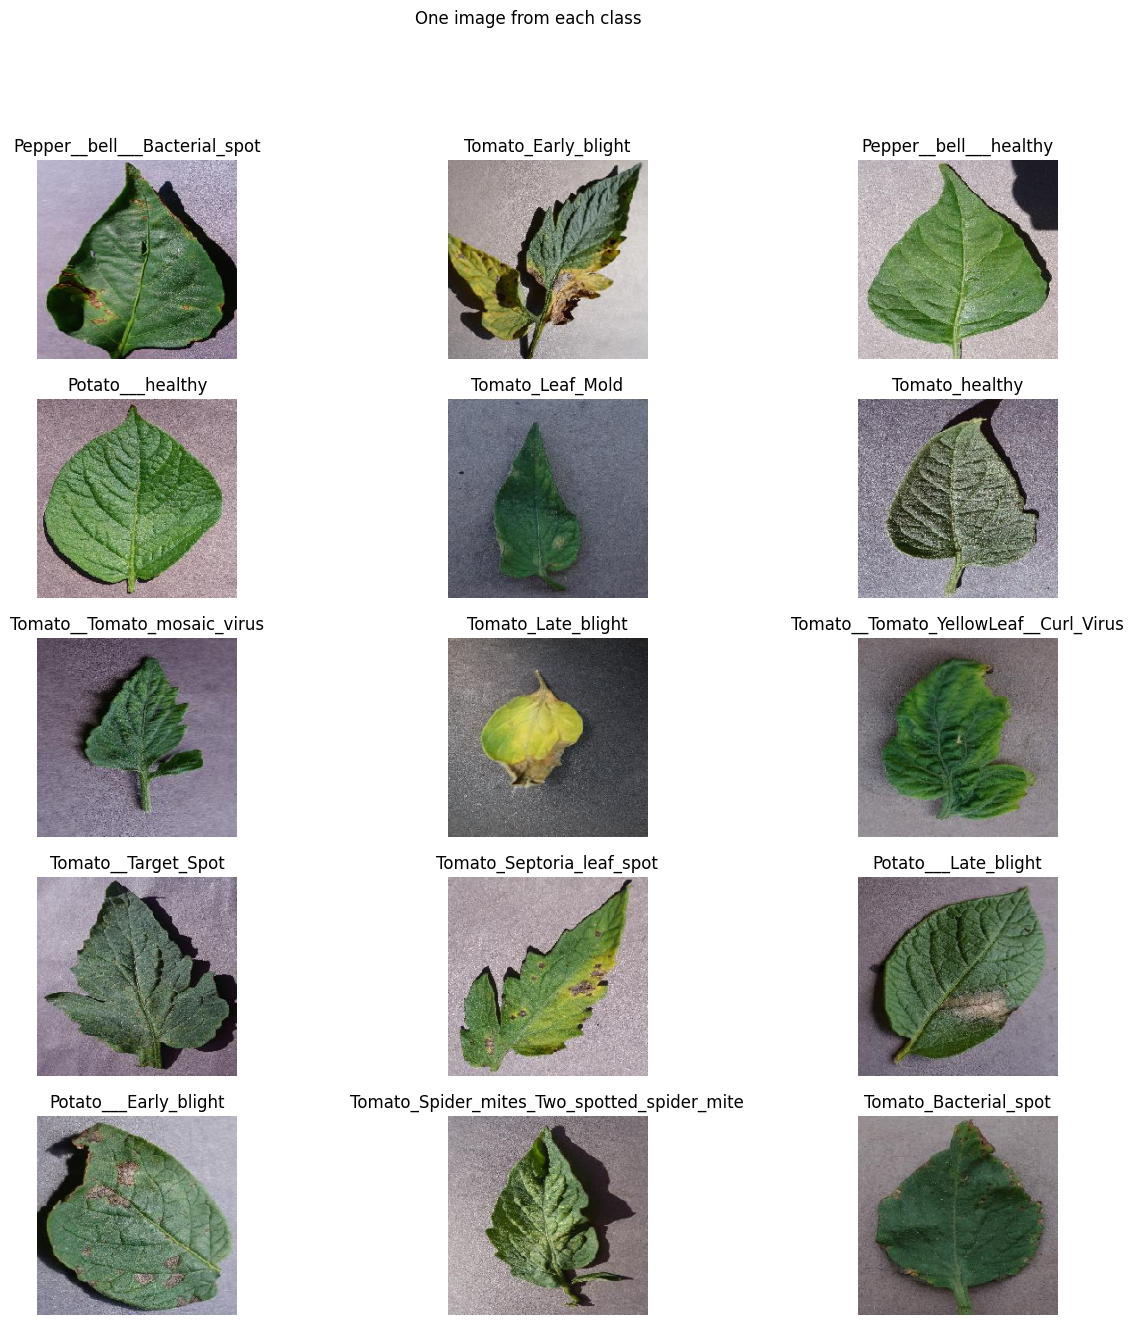

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Base directory of my dataset
base_dir = 'Datasets/plantvillage/PlantVillage'
classes_dir = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Visualizing one image from each class
plt.figure(figsize=(15, 15))
for i, cls in enumerate(classes_dir[:15]):
    cls_folder = os.path.join(base_dir, cls)
    cls_files = os.listdir(cls_folder)
    img_path = os.path.join(cls_folder, cls_files[0])
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(5, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle('One image from each class')
plt.show()

# Desired split: 60% training, 20% validation, 20% testing
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Creating directories for the split dataset
for cls in classes_dir:
    os.makedirs(os.path.join(base_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val', cls), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', cls), exist_ok=True)

    # Get all images in the current class directory
    src_dir = os.path.join(base_dir, cls)
    all_files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    # Split the files
    train_files, test_files = train_test_split(all_files, test_size=1 - train_ratio, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

    # Function to copy files to the new directory structure
    def copy_files(files, src_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(src_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new directories
    copy_files(train_files, src_dir, os.path.join(base_dir, 'train', cls))
    copy_files(val_files, src_dir, os.path.join(base_dir, 'val', cls))
    copy_files(test_files, src_dir, os.path.join(base_dir, 'test', cls))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = 'Datasets/plantvillage/PlantVillage/train'
val_path = 'Datasets/plantvillage/PlantVillage/val'
test_path = 'Datasets/plantvillage/PlantVillage/test'

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_set = val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical')


Found 12377 images belonging to 15 classes.
Found 4127 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


Building the Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob

# Constants
IMAGE_SIZE = [224, 224]

# Loading InceptionV3 as base
base_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Enhancements inspired by VGG and ResNet
x = base_model.output
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)

# Simulated ResNet-style Skip Connection
x_shortcut = x
x = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, x_shortcut])  # Adding back the shortcut
x = Flatten()(x)

# Final prediction layer
folders = glob('Datasets/plantvillage/PlantVillage/train/*')
prediction = Dense(len(folders), activation='softmax')(x)

# Model creation
model = Model(inputs=base_model.input, outputs=prediction)

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Log a message when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with the early stopping callback
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=15,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[early_stopping_callback]  # Add the callback here
)


Epoch 1/15
387/387 [==============================] - 147s 357ms/step - loss: 1.2708 - accuracy: 0.6566 - val_loss: 0.7827 - val_accuracy: 0.7606
Epoch 2/15
387/387 [==============================] - 136s 352ms/step - loss: 0.7910 - accuracy: 0.7518 - val_loss: 0.7008 - val_accuracy: 0.7710
Epoch 3/15
387/387 [==============================] - 133s 344ms/step - loss: 0.6893 - accuracy: 0.7788 - val_loss: 0.7414 - val_accuracy: 0.7773
Epoch 4/15
387/387 [==============================] - 136s 351ms/step - loss: 0.5944 - accuracy: 0.8030 - val_loss: 0.6038 - val_accuracy: 0.8042
Epoch 5/15
387/387 [==============================] - 133s 345ms/step - loss: 0.5998 - accuracy: 0.8064 - val_loss: 0.6663 - val_accuracy: 0.7991
Epoch 6/15
387/387 [==============================] - 135s 349ms/step - loss: 0.5522 - accuracy: 0.8171 - val_loss: 0.5603 - val_accuracy: 0.8221
Epoch 7/15
387/387 [==============================] - 137s 353ms/step - loss: 0.5069 - accuracy: 0.8307 - val_loss: 0.5454 -

Finding the accuracy for test data

In [ ]:
test_loss, test_acc = model.evaluate(test_set, steps=len(test_set))
print('Test accuracy:', test_acc)


130/130 [==============================] - 7s 54ms/step - loss: 0.5188 - accuracy: 0.8488
Test accuracy: 0.8488147258758545


Plots for Model Accuracy and Model Loss

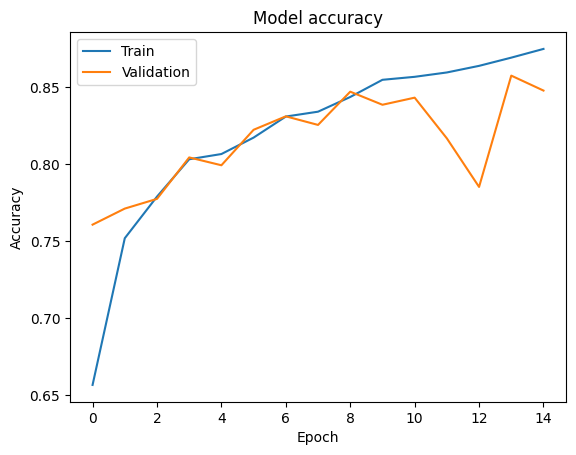

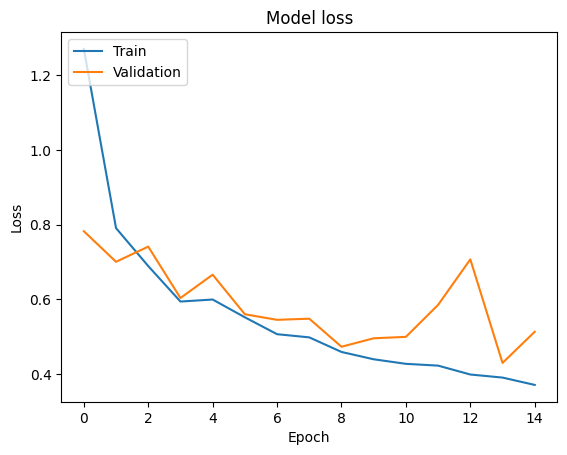

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Saving the model

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Predicting the plant disease

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

# Uploading the image file
uploaded = files.upload()

filename = next(iter(uploaded))  # This gets the name of the uploaded file

# Loading and preprocessing the image
img = image.load_img(filename, target_size=(224, 224))  # Use the uploaded filename
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
preprocessed_img = img_array_expanded_dims / 255.0  # Make sure to match preprocessing used during training

# Predicting the class
prediction = model.predict(preprocessed_img)
predicted_class = np.argmax(prediction, axis=1)

if(predicted_class == [1]):
  # Output the predicted class
  print("The pepper leaf has bacterial spot.")
elif(predicted_class == [2]):
  print("The pepper leaf is healthy.")
elif(predicted_class == [3]):
  print("The potato leaf has early blight.")
elif(predicted_class == [4]):
  print("The potato leaf has late blight.")
elif(predicted_class == [5]):
  print("The potato leaf is healthy.")
elif(predicted_class == [6]):
  print("The tomato leaf has bacterial spot.")
elif(predicted_class == [7]):
  print("The tomato leaf has early blight.")
elif(predicted_class == [8]):
  print("The tomato leaf has late blight.")
elif(predicted_class == [9]):
  print("The tomato leaf has leaf mold.")
elif(predicted_class == [10]):
  print("The tomato leaf has septoria leaf spot.")
elif(predicted_class == [11]):
  print("The tomato leaf has two spotted spider mite.")
elif(predicted_class == [12]):
  print("The tomato leaf has target spot.")
elif(predicted_class == [13]):
  print("The tomato leaf has yellow leaf curl virus.")
elif(predicted_class == [14]):
  print("The tomato leaf has mosaic virus.")
elif(predicted_class == [15]):
  print("The tomato leaf is healthy.")

Saving 607-155-0.jpg to 607-155-0.jpg
1/1 [==============================] - 2s 2s/step
The tomato leaf has leaf mold.


In [ ]:
!pip install web3
!pip install python-dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of eth-rlp to determine which version is compatible with other r